In [1]:
%matplotlib notebook
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))

from genConv import *


In [7]:
def polyHarmonicSpline(x, c, k, eps = 1):    
    centroids = torch.unsqueeze(c, axis = 1)
#     centroidCache[periodic][x.device.type][n] = centroids
#     tx = torch.constant(x, dtype='float32')
    r = torch.abs(torch.unsqueeze(x, axis=0) - centroids) * eps
    
#     if k % 2 == 1:
#         phis = torch.pow(r, k)
#     else:
#         phis = torch.zeros_like(r)
#         phis[r > 1e-7] = torch.pow(r[r > 1e-7], k) * torch.log(r[r > 1e-7]) 
    
#     return phis
    return 1 / torch.sqrt((1 + (eps * r)**2))
    

def polynomialBase(x, n):
    xs = [torch.ones_like(x)]
    for i in range(n):
        xs.append(xs[-1] * x)
    return torch.vstack(xs)

def evalPolyharmonic(x, c, k, a, b):
    print(x.shape, c.shape, k)
    fx = polyHarmonicSpline(x, c, k, eps = 1.)
    px = polynomialBase(x, b.shape[0] - 1)
    print(fx.shape, px.shape)
    
    wfx = torch.sum(a[:,None] * fx, axis = 0)
    wpx = torch.sum(b[:,None] * px, axis = 0)
    print(wfx.shape, wpx.shape)
    return wfx + wpx
def evalPolyharmonic(x, c, k, a, b, normalized = False, eps = 1):
#     print(x.shape, c.shape, k)
    fx = polyHarmonicSpline(x, c, k, eps = eps)
    px = polynomialBase(x, b.shape[0] - 1)
#     print(fx.shape, px.shape)
    if normalized:
        fx = fx / torch.sum(fx, axis = 0)[None, :]
    
    wfx = torch.sum(a[:,None] * fx, axis = 0)
    wpx = torch.sum(b[:,None] * px, axis = 0)
#     print(wfx.shape, wpx.shape)
    return wfx + wpx

res = evalPolyharmonic(torch.linspace(-1,1,256),torch.linspace(-1,1,14),3, torch.rand(14), torch.rand(5))

torch.Size([5, 1024])


<IPython.core.display.Javascript object>


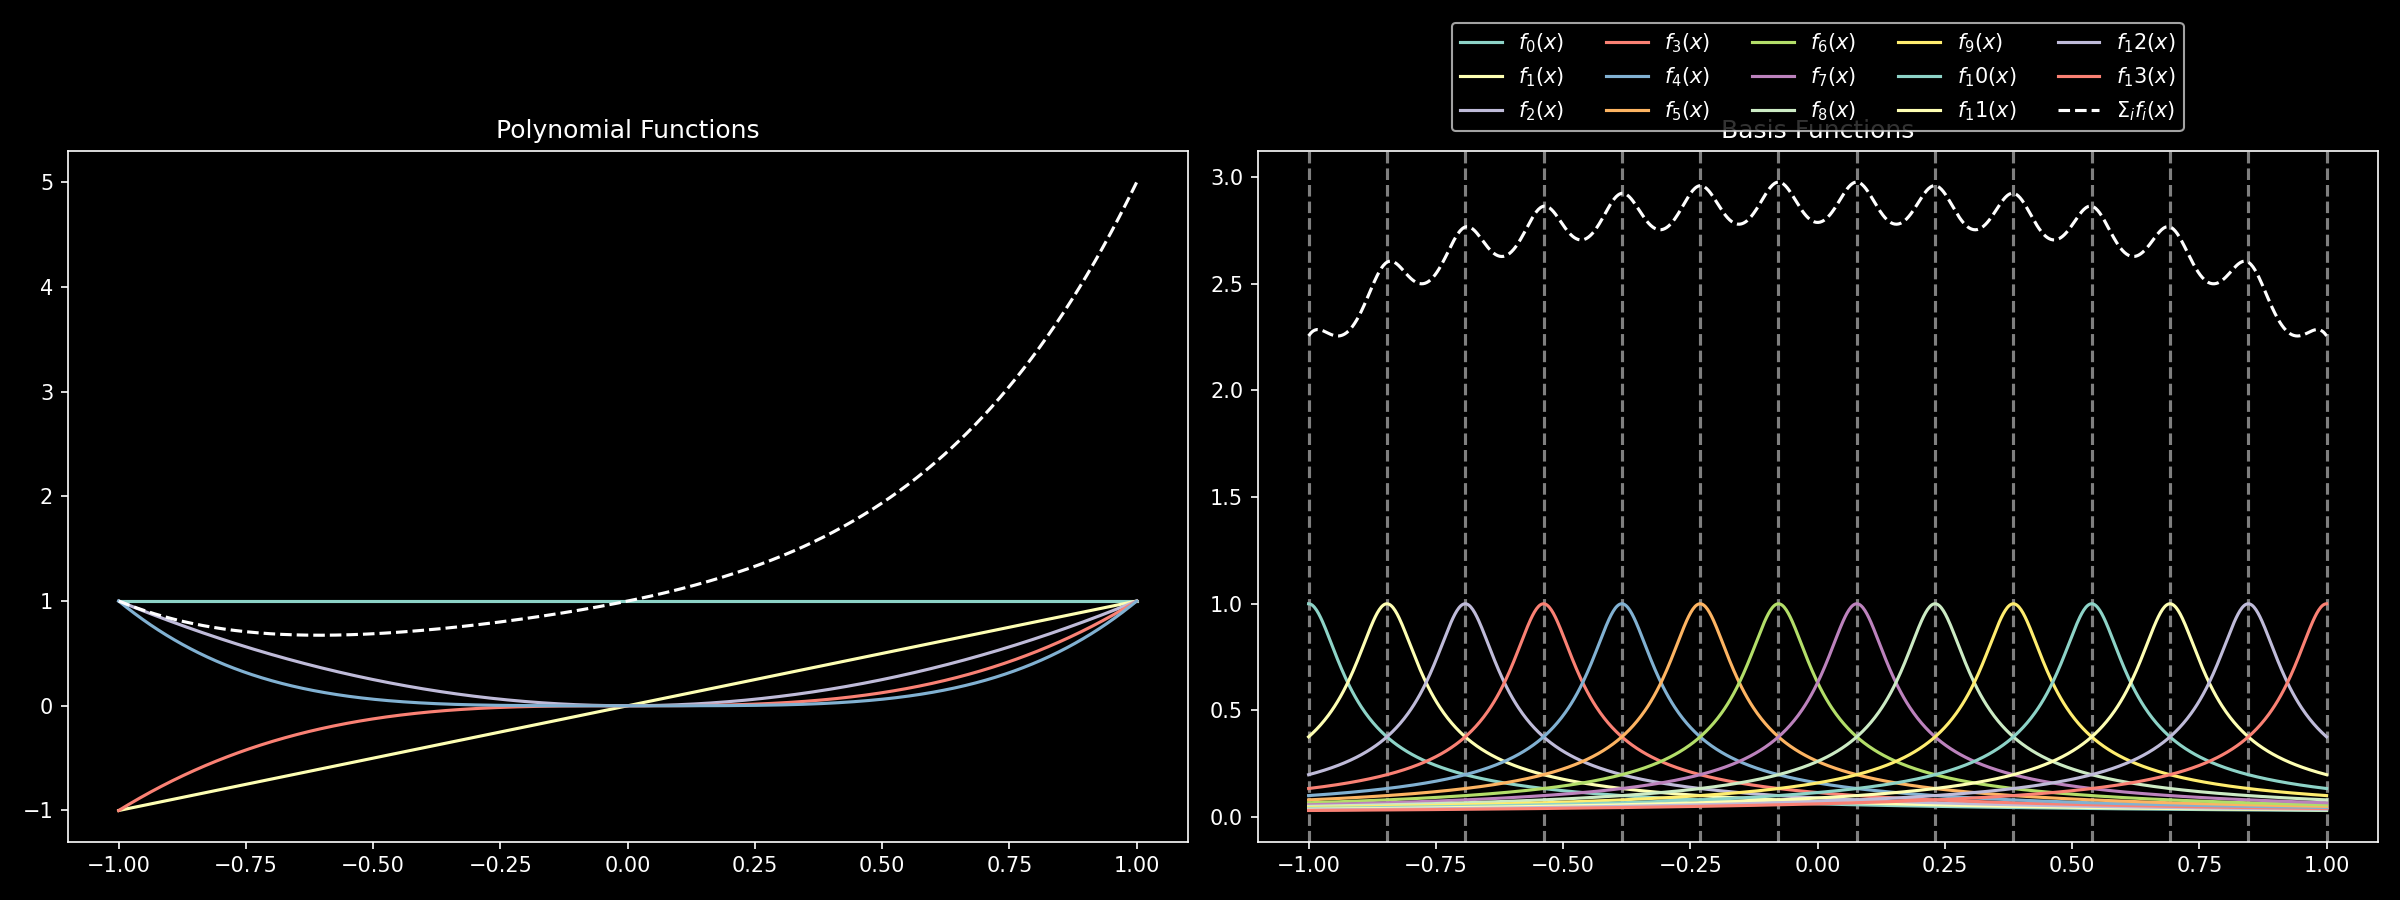

In [9]:
n = 14
x = torch.linspace(-1,1,1024)
c = torch.linspace(-1,1,n)
# c = torch.rand(n) * 2 -1
fx = polyHarmonicSpline(x, c, 4, eps =4)
px = polynomialBase(x, 4)
print(px.shape)

# fx = fx / torch.sum(fx, axis = 0)[None, :]


fig, axis = plt.subplots(1, 2, figsize=(16,6), sharex = False, sharey = False, squeeze = False)
#     sc = axis[0,0].scatter(x, y, c = c, s = 1)
#     ax1_divider = make_axes_locatable(axis[0,0])
#     cax1 = ax1_divider.append_axes("bottom", size="20%", pad="2%")
#     cb1 = fig.colorbar(sc, cax=cax1,orientation='horizontal')
#     cb1.ax.tick_params(labelsize=8) 
#     axis[0,0].axvline(minDomain, color = 'black', ls = '--')
#     axis[0,0].axvline(maxDomain, color = 'black', ls = '--')

# x =  torch.linspace(-1,1,255)
# fx = evalBasisFunction(n, x , which = basis, periodic=False)
# fx = fx / torch.sum(fx, axis = 0)[None,:]

for y in range(n):
    axis[0,1].axvline(c[y], ls = '--', alpha = 0.5)

for y in range(n):
#     print(y)
    axis[0,1].plot(x, fx[y,:], label = '$f_%d(x)$' % y)
axis[0,1].plot(x,torch.sum(fx, axis=0),ls='--',c='white', label = '$\Sigma_i f_i(x)$')
# axis[0,0].legend()
axis[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)
axis[0,1].set_title('Basis Functions')


for y in range(px.shape[0]):
#     print(y)
    axis[0,0].plot(x, px[y,:], label = '$f_%d(x)$' % y)
axis[0,0].plot(x,torch.sum(px, axis=0),ls='--',c='white', label = '$\Sigma_i f_i(x)$')
axis[0,0].set_title('Polynomial Functions')

fig.tight_layout()

<IPython.core.display.Javascript object>


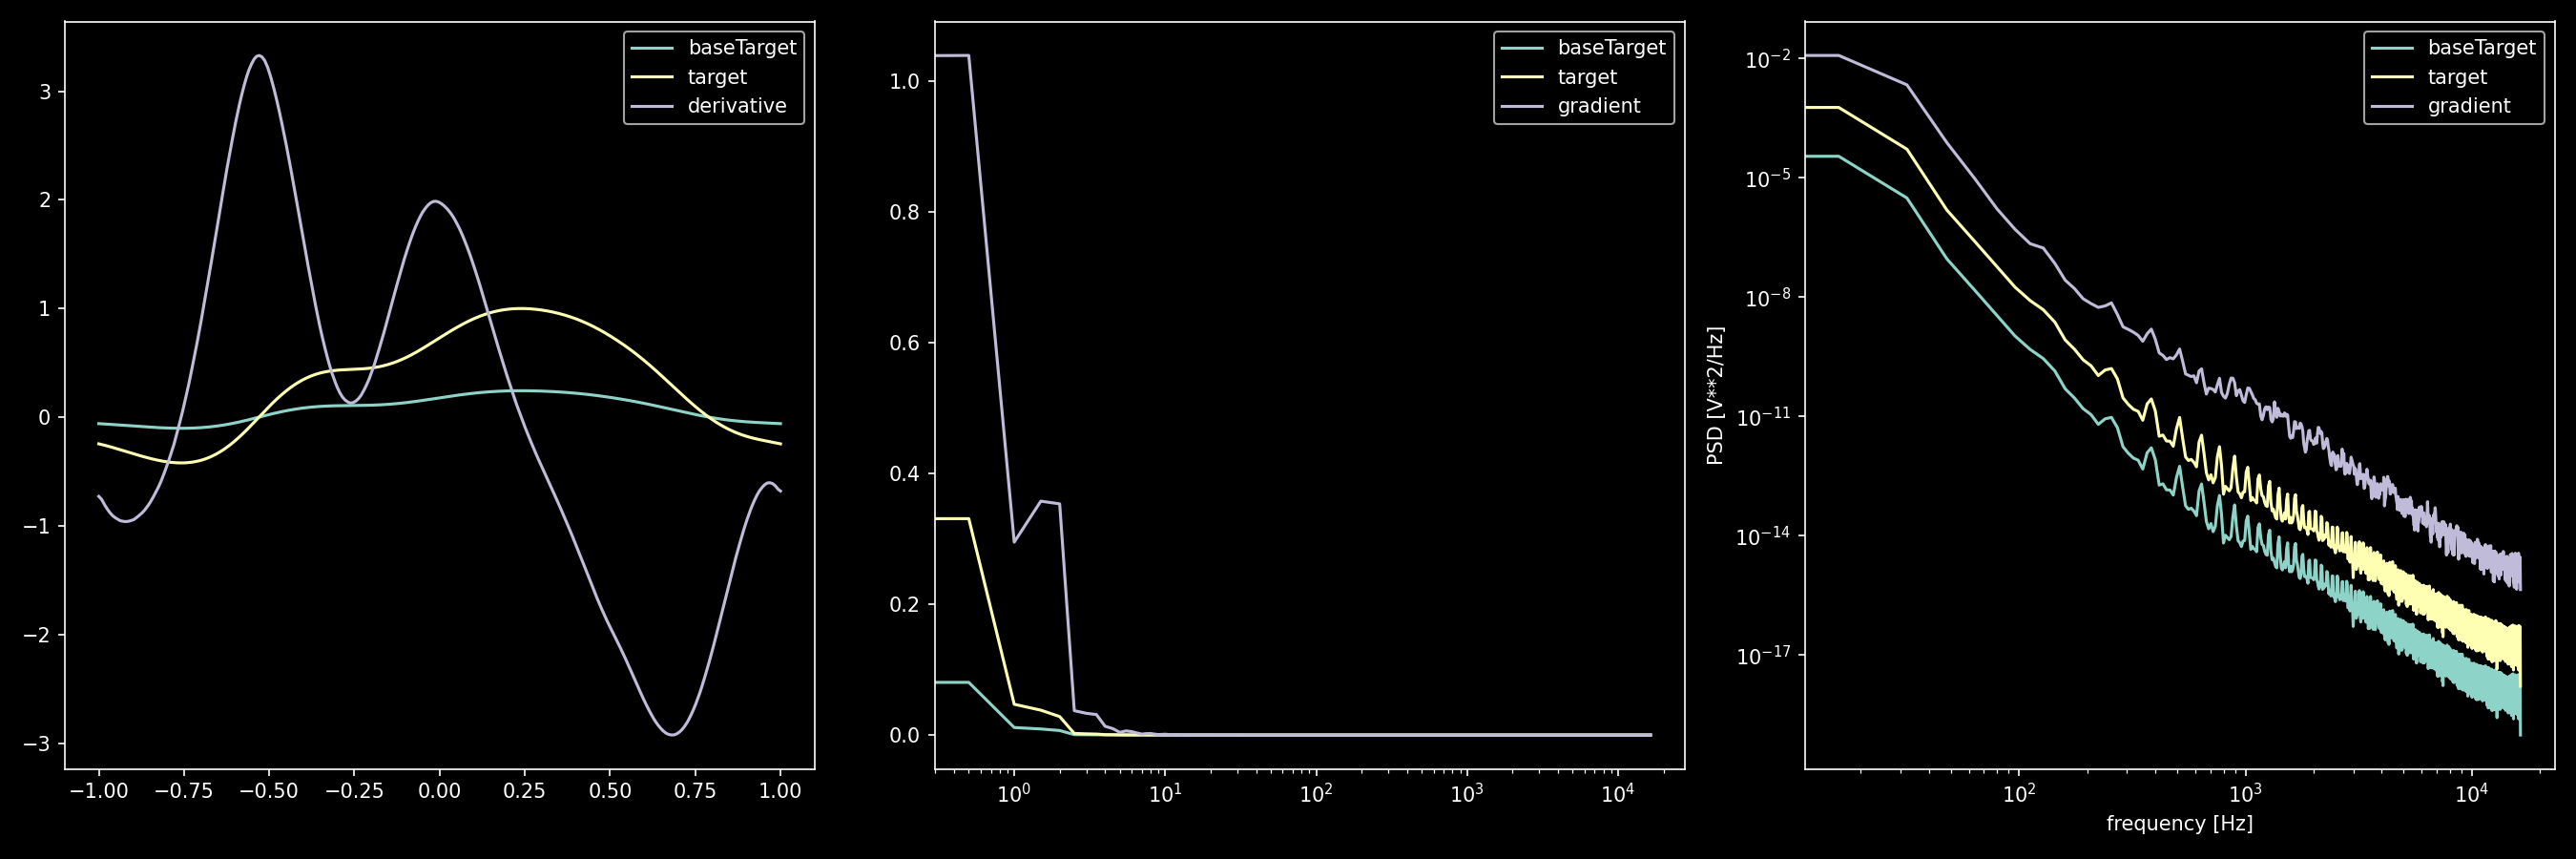

<IPython.core.display.Javascript object>


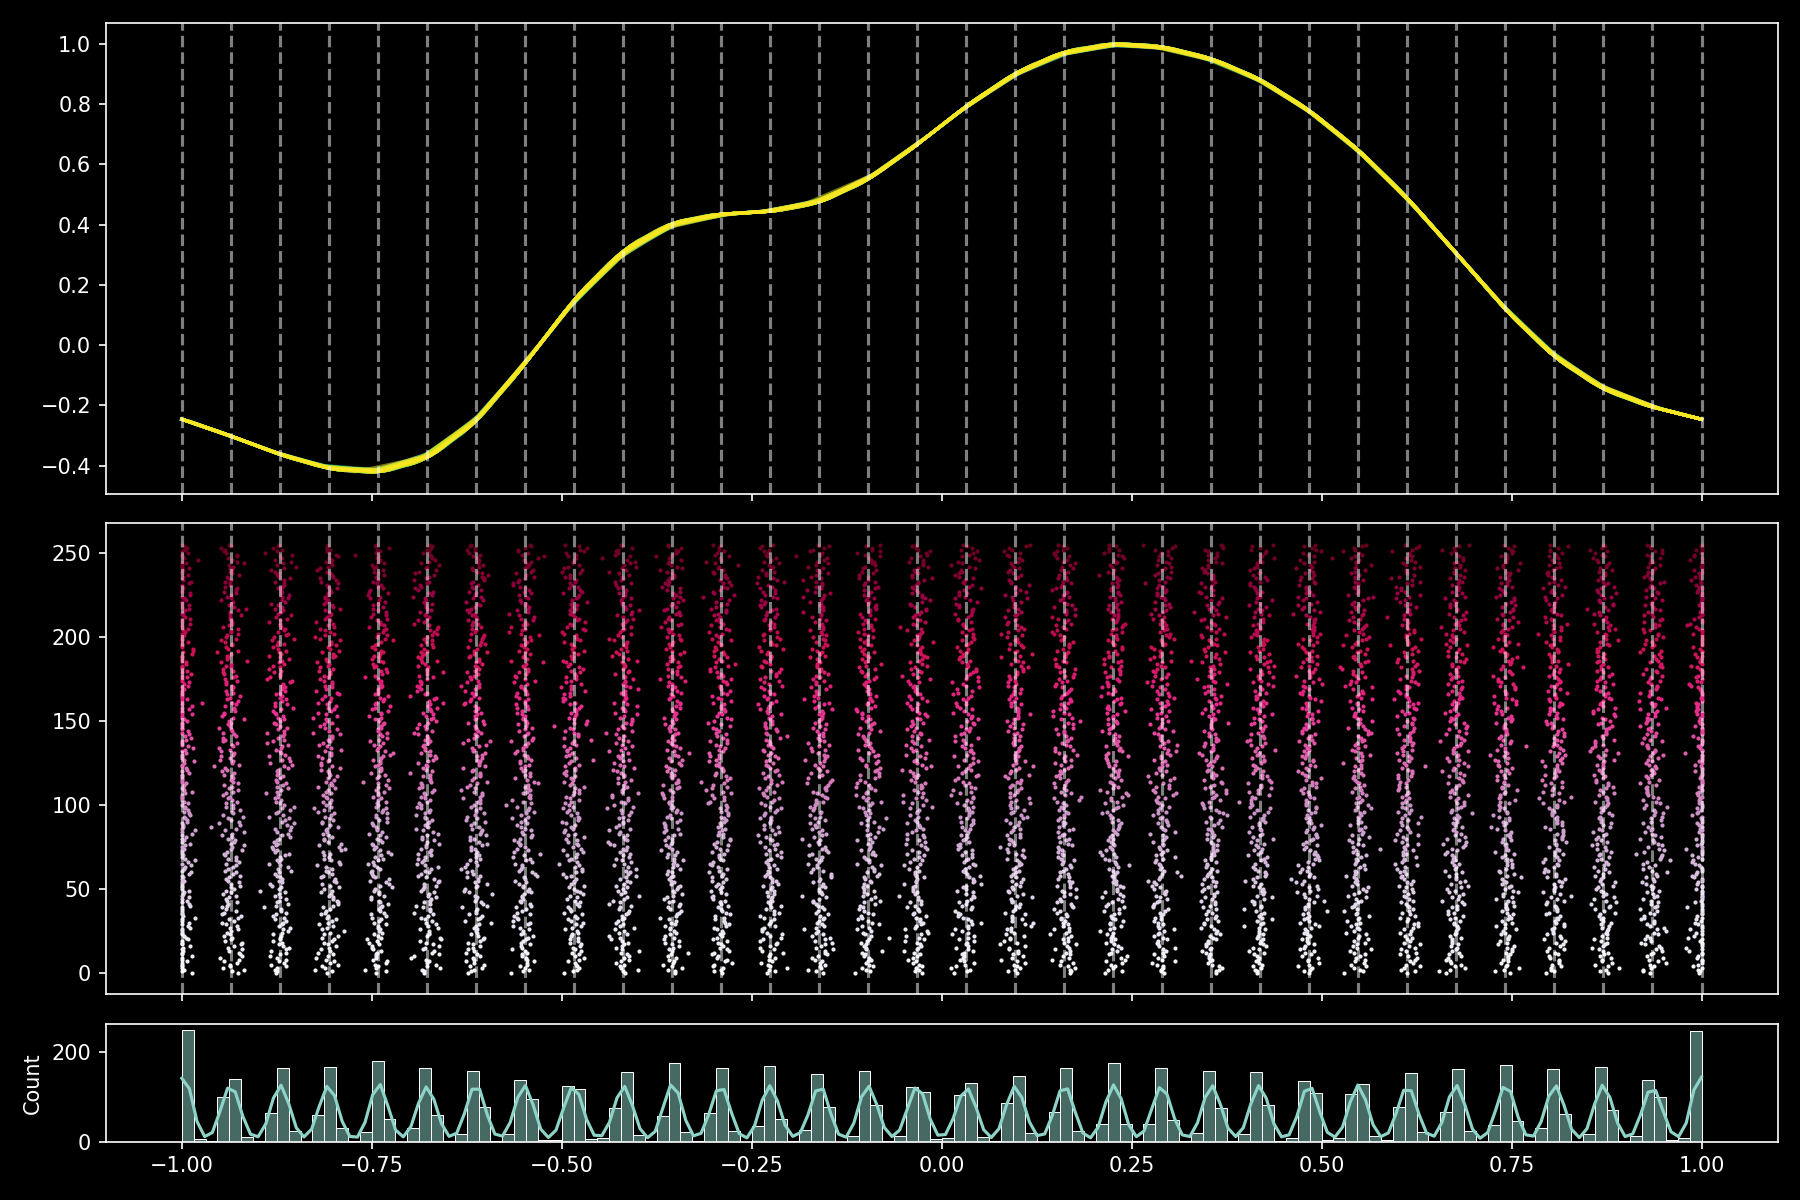

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

In [4]:
n = 8
basis = 'rbf cubic_spline 2'
# basis = 'rbf cubic_spline'
normalizedBasis = False
samples = 256
batch_size = 4
method= 'centered'
dxScale = 8
seed = 0x124567
nPerSample = 32
dx = 2 / (nPerSample-1)
dx = dx

target, _ = generateTargetAndGradientFunction(freq = 2, octaves = 2, seed = 1234, r = 1 / (2 * np.pi), persistence = 0.85, numSamples = 2**16, \
                                normalized = True, periodicNoise = True, window = None, plot = True)    
# _, target = generateTargetAndGradientFunction(freq = 2, octaves = 2, seed = 1234, r = 1 / (2 * np.pi), persistence = 0.85, numSamples = 256, \
#                                 normalized = True, periodicNoise = True, window = 'cubicSpline', baseOverride = None, plot = True, kind = 'cubic')    

dataset = torch.vstack(sample(nPerSample, samples, method = method, dxScale = dxScale, dx = dx, clamped = True, seed = seed))
groundTruth = evalGroundTruth(samples, dataset, target, noise = False, noiseType = 'uniform', noiseVar = 0.25)
# plotDatasetAndGroundtruth(dataset, samples, target, groundTruth)
plotDatasetAndGroundtruthv2(dataset, samples, target, groundTruth)

In [11]:

def plotTrainingPolyHarmonic(nRBF, target, weightList, gradList, lossList, r2List, windowFn = None, plotInterval = 1, plotInitial = True):
    fig, axis = plt.subplots(1, 4, figsize=(18,6), sharex = False, sharey = False, squeeze = False)
    x =  torch.linspace(-1,1,255)
#     fx = evalBasis(n, x, basis, periodic = False, normalized = normalizedBasis) if windowFn is None else evalBasis(n, x, basis, periodic = False, normalized = normalizedBasis) * windowFn(x)[None,:]

    import matplotlib.colors as colors
    norm = colors.LogNorm(vmin=1, vmax=len(weightList))
    losses = []
    evals = []
    r2s = []
    for i, w in enumerate(tqdm(weightList)):
        c = cmap(1 / (len(weightList) - 1)* i)
        c = cmap(norm(i + 1))
    #     for y in range(n):
    #         fy = w[y].detach() * fx[y,:]
    #         axis[1,0].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5,c = c)
#         if i % plotInterval == 0:
#         print(x.shape)
#         print(w, w.shape)
        fx = evalPolyharmonic(x, w[:nRBF].detach(), k, w[nRBF:nRBF*2].detach(), w[nRBF*2:].detach(), normalized = normalized, eps = eps)
        evals.append(fx)
        loss = torch.mean(fx - target(x))**2
        losses.append(loss)
        
        r2s.append(r2_score(target(x), evals[-1].detach().cpu().numpy()))
        if i % 32 == 0:
            axis[0,0].plot(x, fx,c=c)
            
    for c in weightList[-1][:nRBF].detach():
        axis[0,0].axvline(c, c ='white', ls= '--', alpha = 0.5)
#     im = axis[0,3].imshow(torch.vstack(evals), aspect = 'auto', interpolation = 'nearest')
    im = axis[0,3].imshow(torch.vstack(weightList).detach(), aspect = 'auto', interpolation = 'nearest')
    ax1_divider = make_axes_locatable(axis[0,3])
    cax1 = ax1_divider.append_axes("right", size="5%", pad="2%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
    cb1.ax.tick_params(labelsize=8) 
    
    axis[0,0].plot(x, target(x),label = 'Groundtruth',lw=2,c='red',alpha = 0.5)
    axis[0,0].plot(x, evals[-1], label = 'Final Output')
#     if plotInitial:
#         axis[0,0].plot(x, evals[0], label = 'Initial Output')
    axis[0,1].loglog(torch.hstack(losses), label = 'error')
    axis[0,1].loglog(torch.hstack(lossList), label = 'training loss')
    axis[0,1].legend()
    
    
    axis[0,2].semilogx(np.hstack(r2s), label = 'r2')
    axis[0,2].semilogx(np.hstack(r2List), label = 'training r2')
    axis[0,2].legend()
    

    # gradListTensor = torch.vstack(gradList)
    # for i in range(n):
    #     axis[1,1].plot(gradListTensor[:,i])

    # axis[1,1].plot(torch.sum(gradListTensor, axis=1), c = 'white', ls = '--')
    axis[0,0].legend()   
    axis[0,3].set_title('Learning Progress')
    axis[0,1].set_title('Loss %g / %g' % (losses[-1], lossList[-1]))
    axis[0,2].set_title('R2 %g / %g' % (r2s[-1], r2List[-1]))
    # axis[1,0].set_title('Base Functions')
    # axis[1,1].set_title('Gradients')
    axis[0,0].set_title('Interpolant')
    fig.tight_layout()
    

  0%|          | 0/4096 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


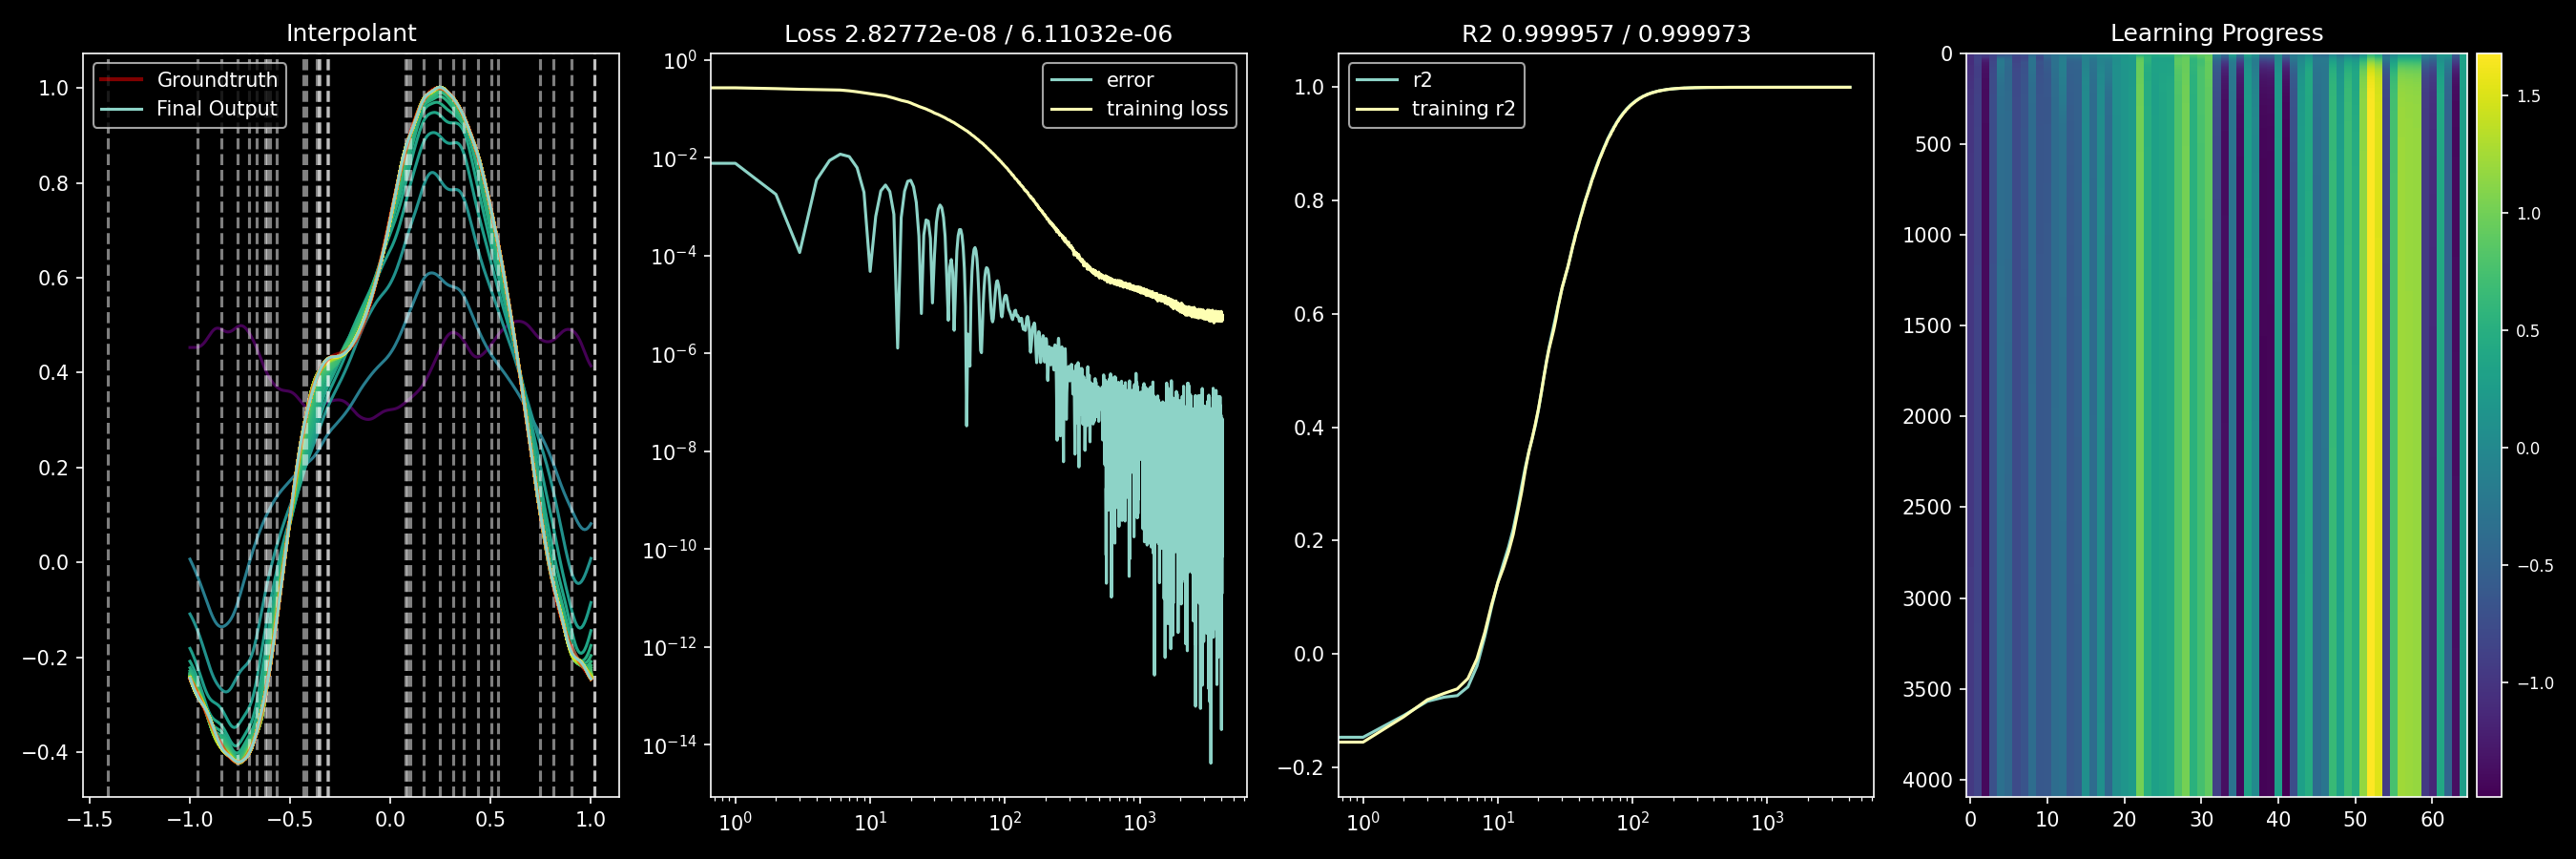

  0%|          | 0/4097 [00:00<?, ?it/s]

In [12]:
import warnings
warnings.filterwarnings("ignore")

n = 8
basis = 'fourier'
# basis = 'rbf cubic_spline 2'
basis = 'rbf cubic_spline 2'
normalizedBasis = False
normalized = True
eps = 4
k = 4
window = 'poly6'
windowFunctionFn = getWindowFunction(window)
windowFunction = lambda x : windowFunctionFn(torch.abs(x))

# print(dataset[0].shape)
# print(groundTruth[0].shape)
train_dataloader, train_iter = generateLoaders(torch.hstack((dataset,groundTruth)), batch_size = batch_size, shuffleDataset = True, shuffled = False, shuffleSeed = None)

def sampleDataLoader():
    global train_dataloder, train_iter
    try:
        bdata = next(train_iter)
    except:
        train_iter = iter(train_dataloader)
        bdata = next(train_iter)
    return bdata

nPolynomial = 0
nRBF = 32

weights = (torch.rand(nPolynomial + 1 + nRBF *2) * 2 - 1) * 0.5
weights[:nRBF] = torch.linspace(-1,1,nRBF)
weights.requires_grad = True
optimizer = optim.SGD([weights], lr=1e-1, momentum=0.9)

weightList = []
gradList = []
lossList = []
r2List = []
weightList.append(torch.clone(weights.detach()))

for i in tqdm(range(2**12)):
    optimizer.zero_grad()
    
    sampled = sampleDataLoader()
#     print(sampled.shape)
    x = sampled[:,:sampled.shape[1]//2].flatten()
    gt = sampled[:,sampled.shape[1]//2:].flatten()
#     print(x.shape)
#     fx = evalPolyharmonic(x,weights[:nRBF], k, weights[nRBF:nRBF*2], weights[nRBF*2:], normalized = True)
    fx = evalPolyharmonic(x,weights[:nRBF], k, weights[nRBF:nRBF*2], weights[nRBF*2:], normalized = normalized, eps = eps)
#     print(fx)
#     fx = evalBasis(n, x, basis, periodic = False, normalized = normalizedBasis) * (windowFunction(x)[None,:] if windowFunction is not None else 1)
    y_pred = fx
    loss = torch.mean((fx - gt)**2)
    r2List.append(r2_score(gt.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))
    
    loss.backward()
    lossList.append(torch.clone(loss.detach()))

    gradList.append(torch.clone(weights.grad.detach()))
    optimizer.step()
    weightList.append(torch.clone(weights))
    

plotTrainingPolyHarmonic(nRBF, target, weightList, gradList, lossList, r2List, plotInterval = 1, windowFn = windowFunction)


  0%|          | 0/4096 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


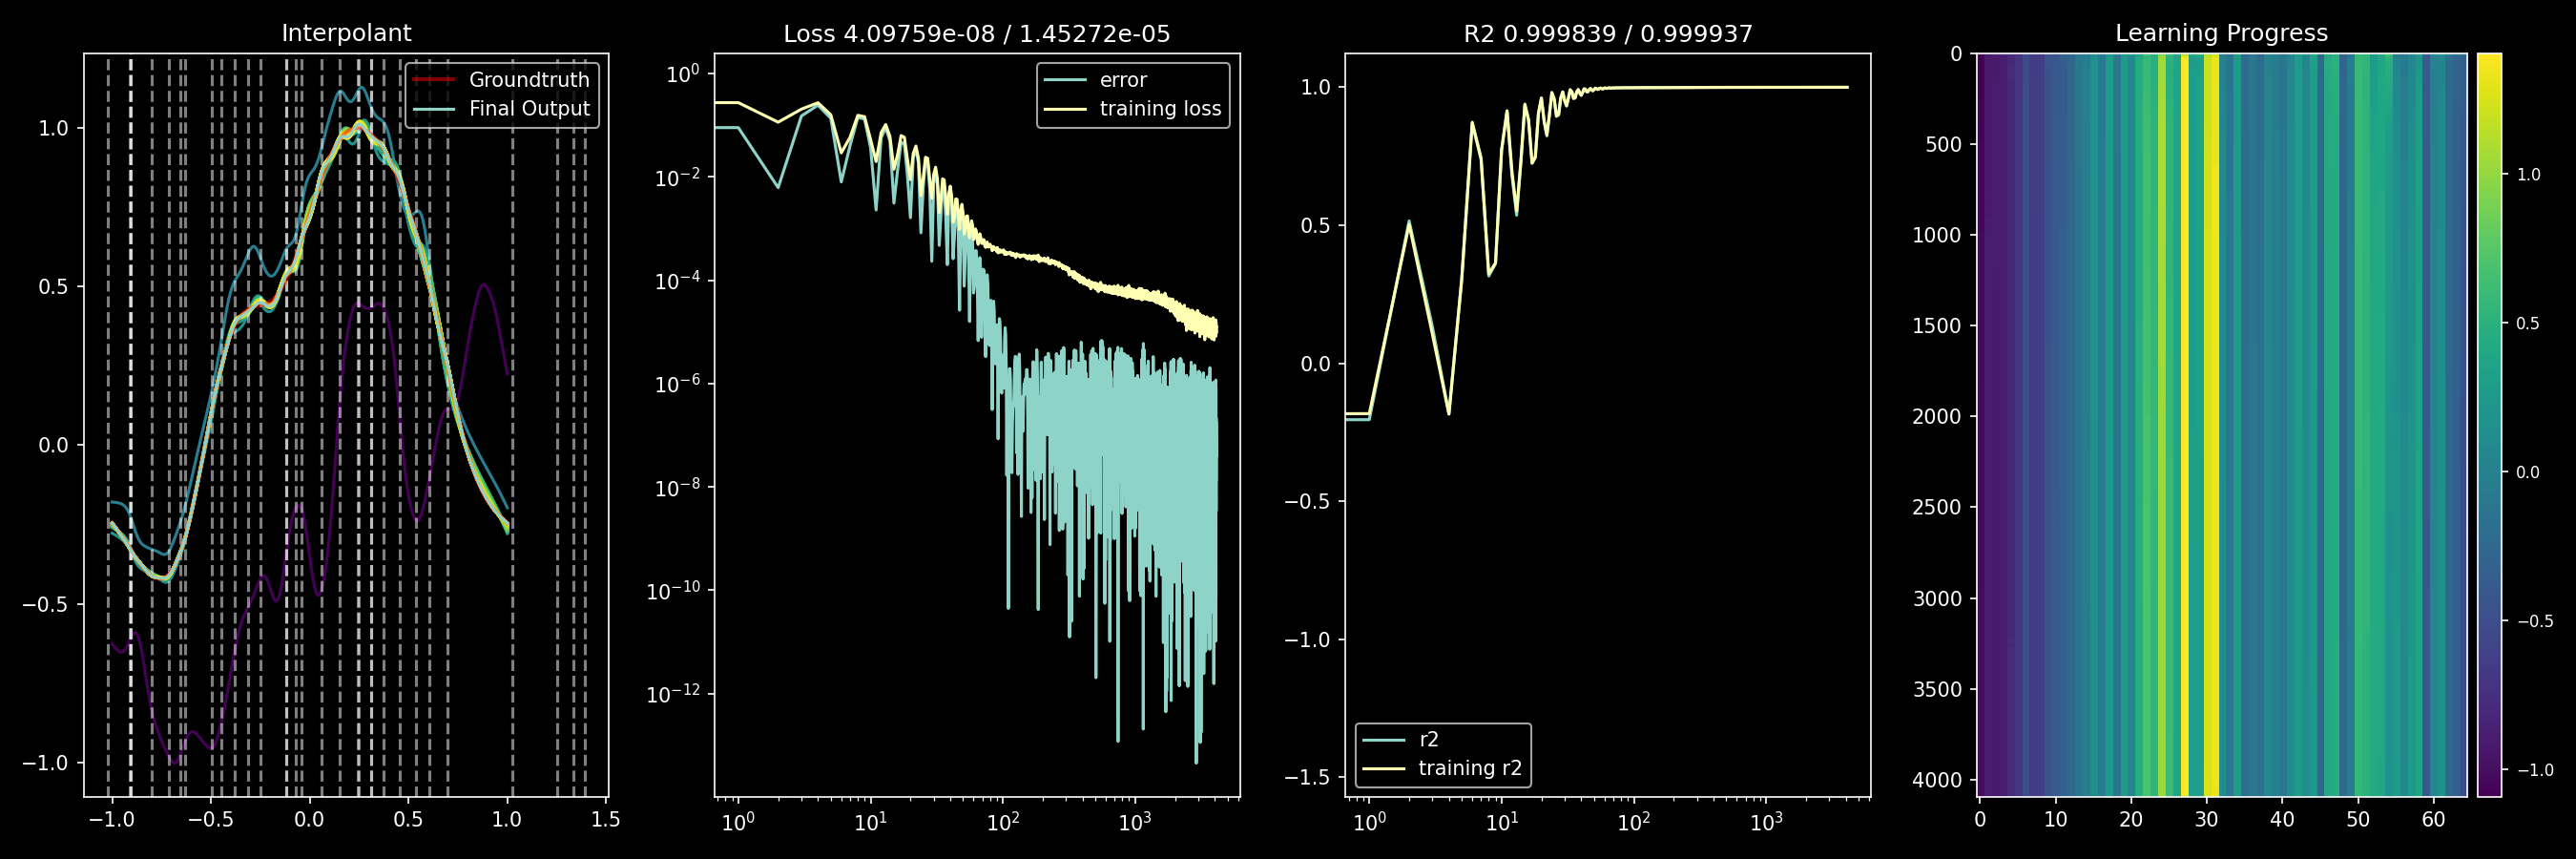

  0%|          | 0/4097 [00:00<?, ?it/s]

In [13]:
import warnings
warnings.filterwarnings("ignore")

n = 8
basis = 'fourier'
# basis = 'rbf cubic_spline 2'
basis = 'rbf cubic_spline 2'
normalizedBasis = False
normalized = False
eps = 4
k = 4
window = 'poly6'
windowFunctionFn = getWindowFunction(window)
windowFunction = lambda x : windowFunctionFn(torch.abs(x))

# print(dataset[0].shape)
# print(groundTruth[0].shape)
train_dataloader, train_iter = generateLoaders(torch.hstack((dataset,groundTruth)), batch_size = batch_size, shuffleDataset = True, shuffled = False, shuffleSeed = None)

def sampleDataLoader():
    global train_dataloder, train_iter
    try:
        bdata = next(train_iter)
    except:
        train_iter = iter(train_dataloader)
        bdata = next(train_iter)
    return bdata

nPolynomial = 0
nRBF = 32

weights = (torch.rand(nPolynomial + 1 + nRBF *2) * 2 - 1) * 0.5
weights[:nRBF] = torch.linspace(-1,1,nRBF)
weights.requires_grad = True
optimizer = optim.SGD([weights], lr=1e-1, momentum=0.9)

weightList = []
gradList = []
lossList = []
r2List = []
weightList.append(torch.clone(weights.detach()))

for i in tqdm(range(2**12)):
    optimizer.zero_grad()
    
    sampled = sampleDataLoader()
#     print(sampled.shape)
    x = sampled[:,:sampled.shape[1]//2].flatten()
    gt = sampled[:,sampled.shape[1]//2:].flatten()
#     print(x.shape)
#     fx = evalPolyharmonic(x,weights[:nRBF], k, weights[nRBF:nRBF*2], weights[nRBF*2:], normalized = True)
    fx = evalPolyharmonic(x,weights[:nRBF], k, weights[nRBF:nRBF*2], weights[nRBF*2:], normalized = normalized, eps = eps)
#     print(fx)
#     fx = evalBasis(n, x, basis, periodic = False, normalized = normalizedBasis) * (windowFunction(x)[None,:] if windowFunction is not None else 1)
    y_pred = fx
    loss = torch.mean((fx - gt)**2)
    r2List.append(r2_score(gt.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))
    
    loss.backward()
    lossList.append(torch.clone(loss.detach()))

    gradList.append(torch.clone(weights.grad.detach()))
    optimizer.step()
    weightList.append(torch.clone(weights))
    

plotTrainingPolyHarmonic(nRBF, target, weightList, gradList, lossList, r2List, plotInterval = 1, windowFn = windowFunction)


  0%|          | 0/4096 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


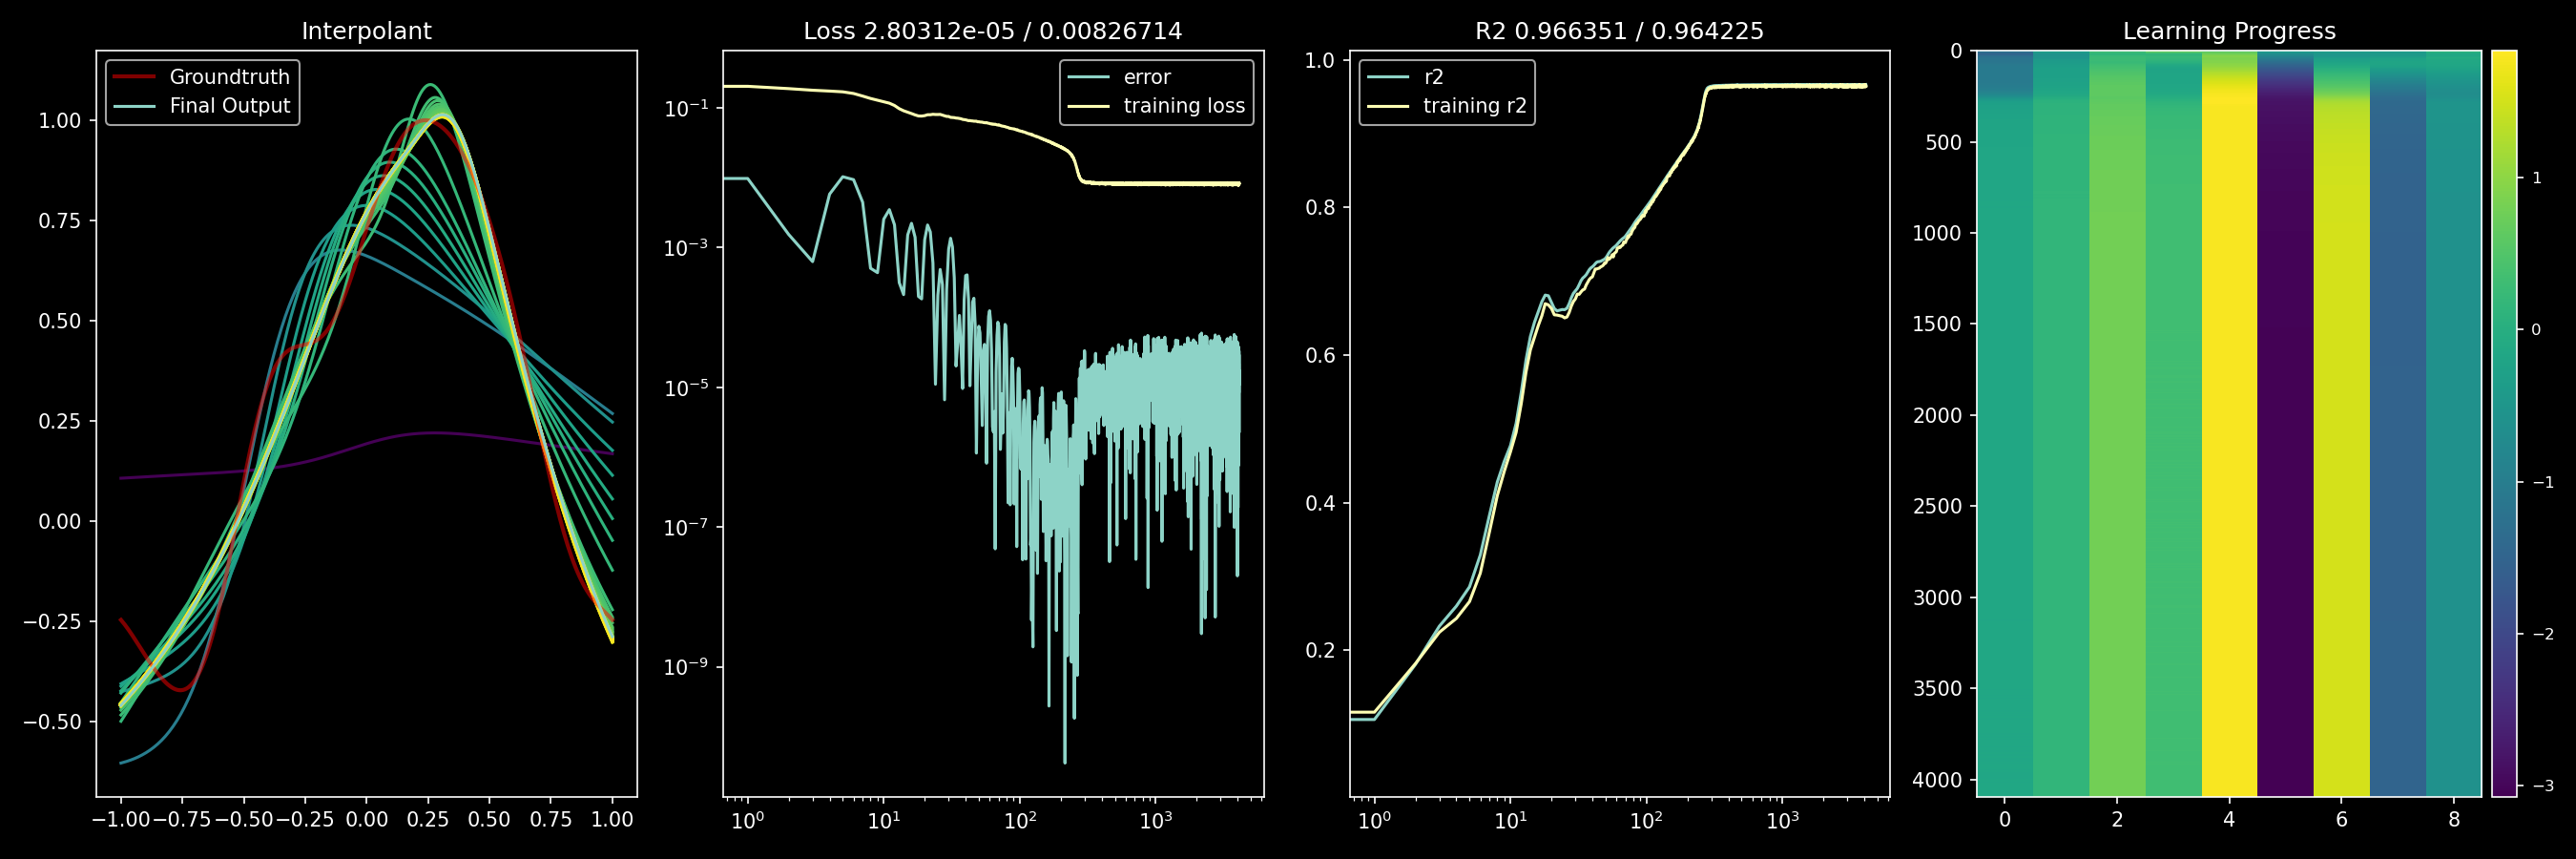

  0%|          | 0/4097 [00:00<?, ?it/s]

In [72]:
import warnings
warnings.filterwarnings("ignore")

n = 8
basis = 'fourier'
# basis = 'rbf cubic_spline 2'
basis = 'rbf cubic_spline 2'
normalizedBasis = False
normalized = True
eps = 0.25
k = 4
window = 'poly6'
windowFunctionFn = getWindowFunction(window)
windowFunction = lambda x : windowFunctionFn(torch.abs(x))

# print(dataset[0].shape)
# print(groundTruth[0].shape)
train_dataloader, train_iter = generateLoaders(torch.hstack((dataset,groundTruth)), batch_size = batch_size, shuffleDataset = True, shuffled = False, shuffleSeed = None)

def sampleDataLoader():
    global train_dataloder, train_iter
    try:
        bdata = next(train_iter)
    except:
        train_iter = iter(train_dataloader)
        bdata = next(train_iter)
    return bdata

nPolynomial = 0
nRBF = 4

weights = (torch.rand(nPolynomial + 1 + nRBF *2) * 2 - 1) * 0.5
weights[:nRBF] = torch.linspace(-1,1,nRBF)
weights.requires_grad = True
optimizer = optim.SGD([weights], lr=1e-1, momentum=0.9)

weightList = []
gradList = []
lossList = []
r2List = []
weightList.append(torch.clone(weights.detach()))

for i in tqdm(range(2**12)):
    optimizer.zero_grad()
    
    sampled = sampleDataLoader()
#     print(sampled.shape)
    x = sampled[:,:sampled.shape[1]//2].flatten()
    gt = sampled[:,sampled.shape[1]//2:].flatten()
#     print(x.shape)
#     fx = evalPolyharmonic(x,weights[:nRBF], k, weights[nRBF:nRBF*2], weights[nRBF*2:], normalized = True)
    fx = evalPolyharmonic(x,weights[:nRBF], k, weights[nRBF:nRBF*2], weights[nRBF*2:], normalized = normalized, eps = eps)
#     print(fx)
#     fx = evalBasis(n, x, basis, periodic = False, normalized = normalizedBasis) * (windowFunction(x)[None,:] if windowFunction is not None else 1)
    y_pred = fx
    loss = torch.mean((fx - gt)**2)
    r2List.append(r2_score(gt.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))
    
    loss.backward()
    lossList.append(torch.clone(loss.detach()))

    gradList.append(torch.clone(weights.grad.detach()))
    optimizer.step()
    weightList.append(torch.clone(weights))
    

plotTrainingPolyHarmonic(nRBF, target, weightList, gradList, lossList, r2List, plotInterval = 1, windowFn = windowFunction)
